<a href="https://colab.research.google.com/github/eordog/erdos_artemis/blob/main/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we start by importing all necessary packages

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

We determine the labels that will be used for classifying different types of tumors. "Back" refers to an MRI scan taken from the back of a patient, "top" is taken from above and "side" is from one side of the patient.

In [ ]:
labels = ['glioma_back', 'glioma_side', 'glioma_top', 'meningioma_back', 'meningioma_side', 'meningioma_top', 
           'no_back', 'no_side', 'no_top', 'pituitary_back', 'pituitary_side', 'pituitary_top']

We go through both training and testing set and merge them first, then convert the images into arrays. 

In [ ]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_Data_12_Categories','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_Data_12_Categories','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


We can see some sample images from each label.

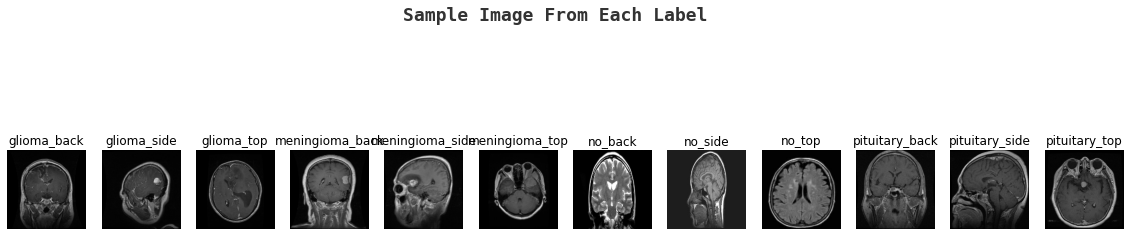

In [ ]:
k=0
fig, ax = plt.subplots(1,12,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

We perform a train-test split, reserving 10% of the training set to test our model.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=607)

Apply one hot encoding for all the labels.

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

Here we use a pre-trained CNN model called InceptionV3. The weights are transferred from ImageNet. To make some modifications in output layers, we have include_top=False. Some further details about the model can be found in the Keras documentation; https://keras.io/api/applications/inceptionv3/

In [ ]:
incv3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax",
)

87924736/87910968 [==============================] - 1s 0us/step


We add an extra layer of GlobalAveragePooling2D which works very similar as MaxPooling2D layer and add another DropOut layer which randomly ignores certain nodes. This helps improve the model's accuracy.

In [ ]:
model = incv3.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(12,activation='softmax')(model)
model = tf.keras.models.Model(inputs=incv3.input, outputs = model)

We can see all the layers in the model by model.summary()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

We compile the model using the optimizer and loss functions given below.

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

We fit the model on the training set, while separating 20% for validation. 

In [ ]:
history = model.fit(X_train, y_train,
  validation_split = 0.2,
  epochs=12,
  batch_size=32,shuffle=True)

Epoch 1/50
83/83 [==============================] - 495s 6s/step - loss: 0.9739 - accuracy: 0.7002 - val_loss: 488.0224 - val_accuracy: 0.1160
Epoch 2/50
83/83 [==============================] - 487s 6s/step - loss: 0.4939 - accuracy: 0.8505 - val_loss: 1.9107 - val_accuracy: 0.4266
Epoch 3/50
83/83 [==============================] - 487s 6s/step - loss: 0.4692 - accuracy: 0.8508 - val_loss: 0.9870 - val_accuracy: 0.6928
Epoch 4/50
83/83 [==============================] - 489s 6s/step - loss: 0.2310 - accuracy: 0.9326 - val_loss: 0.6047 - val_accuracy: 0.8294
Epoch 5/50
83/83 [==============================] - 492s 6s/step - loss: 0.2307 - accuracy: 0.9250 - val_loss: 0.7571 - val_accuracy: 0.8328
Epoch 6/50
83/83 [==============================] - 490s 6s/step - loss: 0.2200 - accuracy: 0.9384 - val_loss: 0.9387 - val_accuracy: 0.7440
Epoch 7/50
83/83 [==============================] - 490s 6s/step - loss: 0.1865 - accuracy: 0.9460 - val_loss: 0.3637 - val_accuracy: 0.9147
Epoch 8/50


We can plot to see how accuracies change in the validation and training set as the model trains. This will help to make necessary modifications in the model.

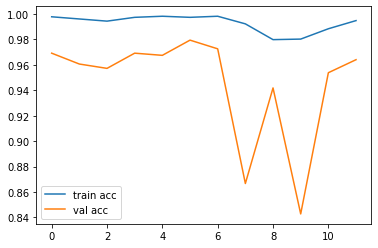

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')

plt.legend()

plt.show()

Similarly, we plot the loss function.

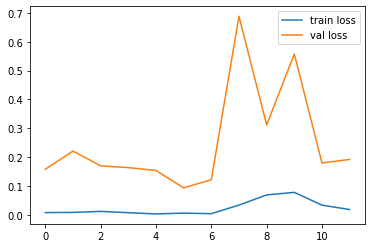

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

Now, we can evaluate our model on the test set. We see that the model achieves an accuracy of 93.8%.

In [ ]:
model.evaluate(X_test, y_test,batch_size=32)

11/11 [==============================] - 1s 43ms/step - loss: 0.2531 - accuracy: 0.9385


[0.2531375586986542, 0.9384615421295166]

We can get the predicted outcome on the rows using argmax.

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

We can evalute the model using classification_report.

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       1.00      0.93      0.96        27
           2       0.88      0.90      0.89        31
           3       0.94      0.94      0.94        33
           4       0.87      0.96      0.92        28
           5       0.86      0.92      0.89        39
           6       1.00      0.67      0.80         6
           7       1.00      0.91      0.95        11
           8       0.98      1.00      0.99        42
           9       0.92      1.00      0.96        22
          10       0.96      0.92      0.94        26
          11       1.00      0.94      0.97        34

    accuracy                           0.94       325
   macro avg       0.95      0.92      0.93       325
weighted avg       0.94      0.94      0.94       325



Confusion matrix is a very useful tool which shows the misclassifications. 

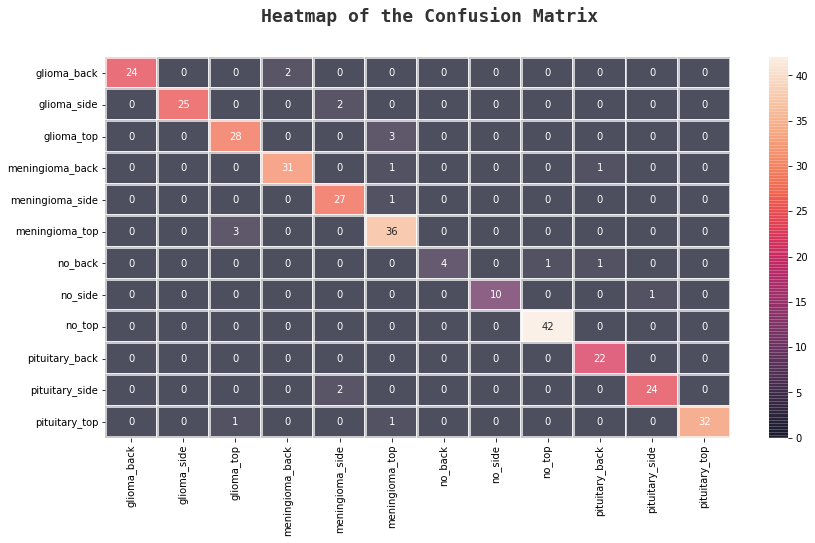

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True
        ,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.95,x=0.28,alpha=0.8)

plt.show()